In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [4]:
# Path to your cleaned Excel file
data_path = "../data/hospital_readmission_cleaned.xlsx"

# Load the Excel file
df = pd.read_excel(data_path)

# Quick check of the data
print("Shape of the dataset:", df.shape)
print("\nColumns in dataset:", df.columns.tolist())
print("\nFirst 5 rows:\n", df.head())

Shape of the dataset: (45095, 19)

Columns in dataset: ['Year', 'Period of coverage', 'Breakdown', 'Level', 'Level description', 'Age Breakdown', 'Sex Breakdown', 'Diagnosis Breakdown', 'Method', 'Indicator value', 'Lower CI (95%)', 'Upper CI (95%)', 'Lower CI (99.8%)', 'Upper CI (99.8%)', 'Numerator', 'Denominator', 'Expected', 'Banding1', 'Warnings2']

First 5 rows:
       Year        Period of coverage Breakdown    Level Level description  \
0  2014/15  01/04/2014 to 31/03/2015   England  England           England   
1  2015/16  01/04/2015 to 31/03/2016   England  England           England   
2  2016/17  01/04/2016 to 31/03/2017   England  England           England   
3  2017/18  01/04/2017 to 31/03/2018   England  England           England   
4  2018/19  01/04/2018 to 31/03/2019   England  England           England   

  Age Breakdown Sex Breakdown    Diagnosis Breakdown Method  Indicator value  \
0           All       Persons  Stroke (I61* to I64*)  Trend             11.6   
1    

In [5]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("(", "").str.replace(")", "")
print(df.columns)

Index(['year', 'period_of_coverage', 'breakdown', 'level', 'level_description',
       'age_breakdown', 'sex_breakdown', 'diagnosis_breakdown', 'method',
       'indicator_value', 'lower_ci_95%', 'upper_ci_95%', 'lower_ci_99.8%',
       'upper_ci_99.8%', 'numerator', 'denominator', 'expected', 'banding1',
       'warnings2'],
      dtype='str')


In [26]:
# Create binary target from indicator_value
# 1 = high risk (indicator_value > 12), 0 = low risk
df['readmission_risk'] = df['indicator_value'].apply(lambda x: 1 if x > 12 else 0)

# Check target distribution
print("\nTarget distribution:\n", df['readmission_risk'].value_counts())


Target distribution:
 readmission_risk
1    25138
0    19957
Name: count, dtype: int64


In [43]:
# Select features
X = df[['age_breakdown', 'sex_breakdown', 'diagnosis_breakdown', 'method', 'breakdown',
        'numerator', 'denominator', 'expected']].copy()

y = df['readmission_risk']

print("Features preview:\n", X.head())
print("\nTarget preview:\n", y.head())

Features preview:
   age_breakdown sex_breakdown    diagnosis_breakdown method breakdown  \
0           All       Persons  Stroke (I61* to I64*)  Trend   England   
1           All       Persons  Stroke (I61* to I64*)  Trend   England   
2           All       Persons  Stroke (I61* to I64*)  Trend   England   
3           All       Persons  Stroke (I61* to I64*)  Trend   England   
4           All       Persons  Stroke (I61* to I64*)  Trend   England   

  numerator denominator  expected  
0      6630       57268    6630.0  
1      6816       58520    6774.9  
2      6834       58586    6782.6  
3      7049       59663    6907.3  
4      7406       60672    7024.1  

Target preview:
 0    0
1    0
2    0
3    0
4    1
Name: readmission_risk, dtype: int64


In [44]:
numeric_cols = ['numerator', 'denominator', 'expected']
for col in numeric_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X[col].fillna(0, inplace=True)

C:\Users\O M E N\AppData\Local\Temp\ipykernel_3788\3626672364.py:4: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  X[col].fillna(0, inplace=True)


In [45]:
# Categorical columns
categorical_cols = ['age_breakdown', 'sex_breakdown', 'diagnosis_breakdown', 'method', 'breakdown']

for col in ['diagnosis_breakdown', 'method']:
    X[col] = X[col].astype(str).str.replace("*", "", regex=False).str.replace("(", "", regex=False).str.replace(")", "", regex=False)

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_encoded = X_encoded.astype(float)

print("Encoded features preview:\n", X_encoded.head())
print("Number of features after encoding:", X_encoded.shape[1])




Encoded features preview:
    numerator  denominator  expected  sex_breakdown_Male  \
0     6630.0      57268.0    6630.0                 0.0   
1     6816.0      58520.0    6774.9                 0.0   
2     6834.0      58586.0    6782.6                 0.0   
3     7049.0      59663.0    6907.3                 0.0   
4     7406.0      60672.0    7024.1                 0.0   

   sex_breakdown_Persons  diagnosis_breakdown_Stroke I61 to I64  \
0                    1.0                                    1.0   
1                    1.0                                    1.0   
2                    1.0                                    1.0   
3                    1.0                                    1.0   
4                    1.0                                    1.0   

   breakdown_CCG/sub-ICB  breakdown_Deprivation quintile  breakdown_England  \
0                    0.0                             0.0                1.0   
1                    0.0                             0.0 

In [46]:
# Fill all remaining NaNs with column mean
X_encoded = X_encoded.fillna(X_encoded.mean())

In [39]:
scaler = StandardScaler()
numeric_features = ['indicator_value', 'numerator', 'denominator', 'expected']
X_encoded[numeric_features] = scaler.fit_transform(X_encoded[numeric_features])


Accuracy: 0.617363344051447
Precision: 0.6482979123565921
Recall: 0.6855608591885441
F1 Score: 0.6664088931851135


c:\Users\O M E N\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


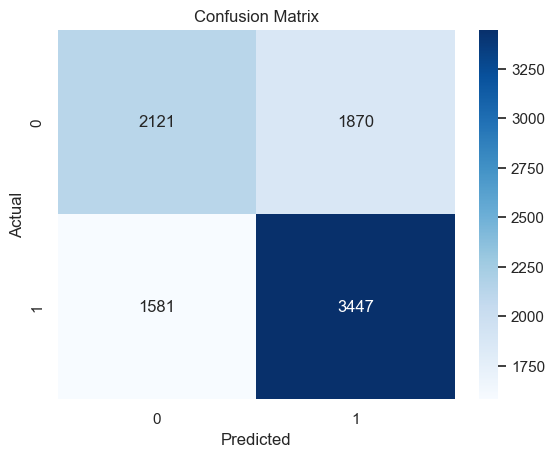


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.53      0.55      3991
           1       0.65      0.69      0.67      5028

    accuracy                           0.62      9019
   macro avg       0.61      0.61      0.61      9019
weighted avg       0.61      0.62      0.62      9019



In [47]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [48]:
coefficients = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': lr_model.coef_[0]
})
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)
print("\nTop features impacting readmission risk:\n", coefficients.head(15))


Top features impacting readmission risk:
                                   Feature  Coefficient  Abs_Coefficient
5   diagnosis_breakdown_Stroke I61 to I64    -0.711651         0.711651
9    breakdown_Lower tier local authority    -0.355434         0.355434
12                       breakdown_Region     0.286002         0.286002
10           breakdown_NHS England Region     0.195267         0.195267
6                   breakdown_CCG/sub-ICB    -0.159997         0.159997
7          breakdown_Deprivation quintile    -0.134558         0.134558
11                     breakdown_Provider    -0.100465         0.100465
3                      sex_breakdown_Male     0.090938         0.090938
13                      breakdown_STP/ICB    -0.087747         0.087747
4                   sex_breakdown_Persons     0.073454         0.073454
8                       breakdown_England     0.015349         0.015349
0                               numerator     0.003229         0.003229
2                    